In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2 # 특징 선택을 위한 라이브러리
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline

In [ ]:
# 데이터 불러오기
dataset_path = '/content/mushroom+dataset.csv'
data = pd.read_csv(dataset_path)
data.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


In [ ]:
# 전처리 준비 과정
print(data.isnull().sum())

# Label 인코딩
le = LabelEncoder()
for col in data.columns:
    data[col] = le.fit_transform(data[col])

# 확인
data.info()

X = data.drop('class', axis=1)  # Label 분리
y = data['class']

cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
class                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   cap-shape                 8124 non-null   int64
 1   cap-surface               

In [ ]:
# 특징 선택 시작
selector = SelectKBest(chi2, k=5)  # K=5 로 일단,
X_selected = selector.fit_transform(X, y)

selected_features = np.array(X.columns)[selector.get_support()]
print(selected_features)
# 선택된 애들 출력

['bruises' 'gill-size' 'gill-color' 'stalk-root' 'ring-type']


In [ ]:
# 7 : 3 으로 일단 분리
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [ ]:
# 결정 트리와 랜덤 포레스트 모델을 사용
rf = RandomForestClassifier(random_state=1)
dt = DecisionTreeClassifier(random_state=1)

rf.fit(X_train, y_train)
dt.fit(X_train, y_train)

rf_predicteds = rf.predict(X_test)
dt_predicteds = dt.predict(X_test)

결정 트리 정확도: 0.9737489745693191 F1: 0.9736621246525295
랜덤 포레스트 정확도 : 0.9737489745693191 F1: 0.9736621246525295


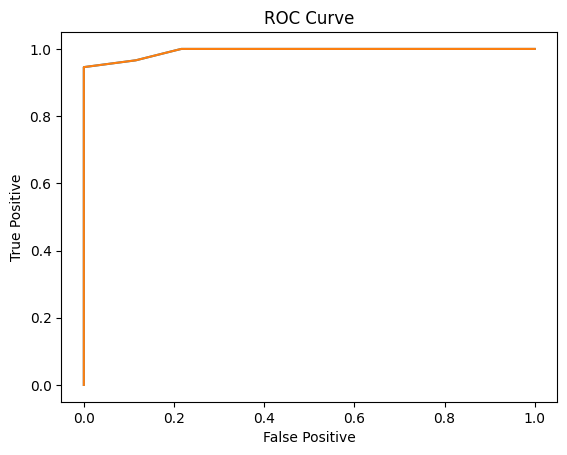

In [ ]:
# 정확도, F1 점수, ROC 곡선
rf_accuracy = accuracy_score(y_test, rf_predicteds)
dt_accuracy = accuracy_score(y_test, dt_predicteds)

rf_f1 = f1_score(y_test, rf_predicteds, average='macro')
dt_f1 = f1_score(y_test, dt_predicteds, average='macro')

print("결정 트리 정확도:", dt_accuracy, "F1:", dt_f1)
print("랜덤 포레스트 정확도 :", rf_accuracy, "F1:", rf_f1)

rf_probs = rf.predict_proba(X_test)[:, 1]
dt_probs = dt.predict_proba(X_test)[:, 1]

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)

rf_auc = auc(rf_fpr, rf_tpr)
dt_auc = auc(dt_fpr, dt_tpr)

# 한글 들어오면 깨짐
plt.figure()
plt.plot(rf_fpr, rf_tpr)
plt.plot(dt_fpr, dt_tpr)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC Curve")
plt.show()

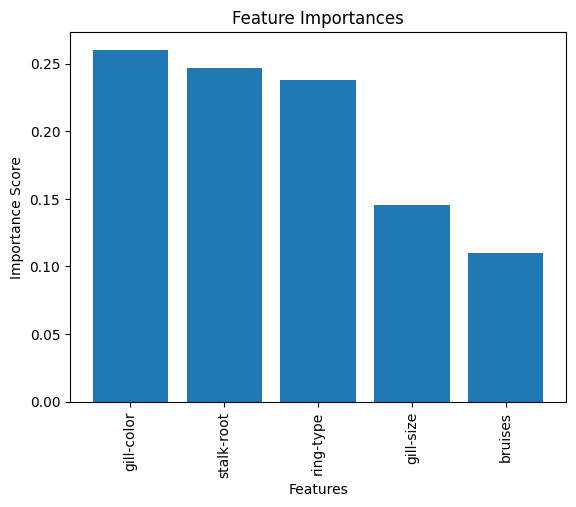

In [ ]:
# 랜덤 포레스트에서 특징 중요도 평가
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_selected.shape[1]), importances[indices], align="center")
plt.xticks(range(X_selected.shape[1]), selected_features[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()

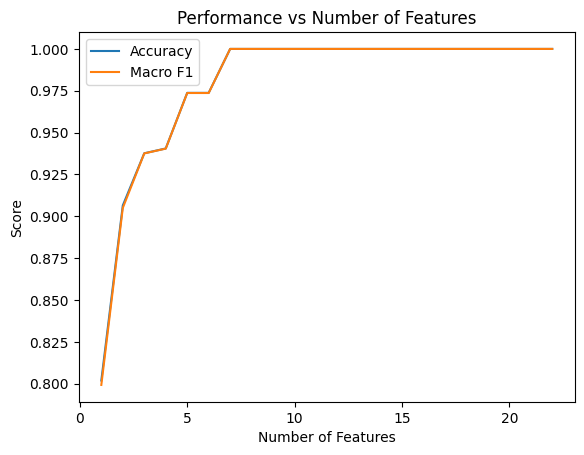

In [ ]:
# 특징 수에 따른 분류 성능 변화 살펴보기
accuracies = []
f1_scores = []

for k in range(1, X.shape[1] + 1):
    selector = SelectKBest(chi2, k=k)
    X_k_best = selector.fit_transform(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X_k_best, y, test_size=0.3, random_state=42)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='macro')

    accuracies.append(acc)
    f1_scores.append(f1)

plt.figure()
plt.plot(range(1, X.shape[1] + 1), accuracies, label="Accuracy")
plt.plot(range(1, X.shape[1] + 1), f1_scores, label="Macro F1")
plt.xlabel("Number of Features")
plt.ylabel("Score")
plt.title("Performance vs Number of Features")
plt.show()